In [115]:
import os
import json
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from model import HighResolutionNet
import transforms
import random
#import torchjpeg
#from torchjpeg import dct
from torch.nn import functional as F
import torchvision.transforms as transform
import torchvision
import draw_utils
from pytorch_wavelets import DWTForward, DWTInverse
from torchvision.transforms.functional import to_pil_image
from PIL import Image

In [116]:
def reconstruct_image_from_xnoise_resized(x_noise):
    idwt = DWTInverse(mode='zero', wave='haar').to(x_noise.device)
    Yh = build_Yh_list_from_xnoise_v2(x_noise, levels=3)
    Yl = create_zero_Yl_like(x_noise, levels=3)
    x_recon = idwt((Yl, Yh))  # [B, 3, H, W]
    
    return x_recon

def create_zero_Yl_like(x_noise, levels=2):
    B, _, H, W = x_noise.shape
    scale = 2 ** levels
    H_l, W_l = H // scale, W // scale
    yl = torch.zeros(B, 3, H_l, W_l, device=x_noise.device)
    #print(yl.shape)
    return yl

def build_Yh_list_from_xnoise_v2(x_noise: torch.Tensor, levels: int = 3):
    """
    Build Yh: List of 3 tensors, each [B, 3, 3, H_l, W_l] for IDWT.
    """
    B, C, H, W = x_noise.shape
    chs_per_level = C // levels  # 48 channels per level if 144 total

    assert chs_per_level >= 9, "Each level must contain at least 9 channels for [3, 3] structure"

    Yh = []

    for i in range(levels):
        x_level = x_noise[:, i * chs_per_level: (i + 1) * chs_per_level, :, :]  # [B, 48, H, W]
        x_part = x_level[:, :9, :, :]  # [B, 9, H, W]

        # Downsample spatially
        scale = 2 ** (i+1)
        H_l, W_l = H // scale, W // scale
        x_resized = F.interpolate(x_part, size=(H_l, W_l), mode='bilinear', align_corners=False)  # [B, 9, H_l, W_l]

        # Reshape to [B, 3, 3, H_l, W_l]
        x_reshaped = x_resized.view(B, 3, 3, H_l, W_l)
        Yh.append(x_reshaped)
    #print('yh[0]', Yh[0].shape)
    #print('yh[1]',Yh[1].shape)
    #print('yh[2]',Yh[2].shape)
    return Yh

def tensor_rgb(tensor_img, resize_hw=(612, 640)):
    #os.makedirs(save_dir, exist_ok=True)
    B = tensor_img.shape[0]
    for i in range(B):
        img = tensor_img[i]
        if img.dtype != torch.uint8:
            img = (img * 255).clamp(0, 255).to(torch.uint8)
        img_pil = to_pil_image(img.cpu())
        img = img_pil.resize((resize_hw[1], resize_hw[0]), resample=Image.BILINEAR)
    print(img.size)
    return img

In [117]:
def predict_uncoco_person(coco, image_id, img, annotations, device, model, data_transform, images):
    plot_img = img.copy()
    print(plot_img.shape)
    output_0, loss_0, x_wave_0, x_noise_0 = model(images)
    rgb_out = reconstruct_image_from_xnoise_resized(x_noise_0)

    plot_img = tensor_rgb(rgb_out)
    print(plot_img.size)
    #plot_img.resize((640, 427))
    plt.axis('off')
    plt.imshow(plot_img)
    plt.savefig('test_result_all_person_original_1.png', format='png')
    '''
    transformm = transform.ToTensor()
    temp = []
    temp.append(plot_img)
    
    plot_img = torch.stack([transformm(i).to("cpu") for i in temp])
    
    plot_img = dct_transform(plot_img, chs_remove = [0, 1, 2, 3, 8, 9, 10, 16, 17, 24, 39, 46, 47,53, 54, 55, 60, 61, 62, 63])
    plot_img = idct_transform(plot_img)
    plot_img = plot_img.squeeze(0)
    plot_img = plot_img.permute(1, 2, 0).numpy()

    plot_img = (plot_img - plot_img.min()) / (plot_img.max() - plot_img.min())
    plot_img = (plot_img * 255).astype(np.uint8)'''
        
        
    
    
    img_tensor, target = data_transform(img_crop, {"box": [0, 0, w - 1, h - 1]})
    img_tensor = torch.unsqueeze(img_tensor, dim=0)
    #images = dct_transform(img_tensor, chs_remove=[0, 1, 2, 3, 8, 9, 10, 16, 17, 24, 39, 46, 47, 53, 54, 55, 60, 61, 62, 63])

    with torch.inference_mode():
        outputs, loss, x_wave, x_noise = model(img_tensor.to(device))
        keypoints, scores = transforms.get_final_preds(outputs, [target["reverse_trans"]], True)
        keypoints = np.squeeze(keypoints)
        scores = np.squeeze(scores)
        plot_img = draw_utils.draw_keypoints(plot_img, keypoints + [x, y], scores, thresh=0.2, r=5)
    
    return plot_img

In [118]:
def predict_all_person(coco, image_id, img, annotations, device, model, data_transform, images):
    #plot_img = img.copy()
    print(images.shape)
    output_0, loss_0, x_wave_0, x_noise_0 = model(images)
    rgb_out = reconstruct_image_from_xnoise_resized(x_noise_0)

    plot_img = tensor_rgb(rgb_out)
    print(plot_img.size)
    #plot_img = cv2.resize(plot_img, (640, 426))
    plot_img.resize((426, 640))
    plt.axis('off')
    plt.imshow(plot_img)
    plt.savefig('test_result_all_person_original_1.png', format='png')
    
        
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = bbox
        x, y, w, h = int(x), int(y), int(w), int(h)
        img_crop = img[y:y+h, x:x+w]
        img_tensor, target = data_transform(img_crop, {"box": [0, 0, w - 1, h - 1]})
        img_tensor = torch.unsqueeze(img_tensor, dim=0)
        #images = dct_transform(img_tensor, chs_remove=[0, 1, 2, 3, 8, 9, 10, 16, 17, 24, 39, 46, 47, 53, 54, 55, 60, 61, 62, 63])

        with torch.inference_mode():
            outputs, loss, x_wave, x_noise = model(img_tensor.to(device))
            keypoints, scores = transforms.get_final_preds(outputs, [target["reverse_trans"]], True)
            keypoints = np.squeeze(keypoints)
            scores = np.squeeze(scores)
            plot_img = draw_utils.draw_keypoints(plot_img, keypoints + [x, y], scores, thresh=0.2, r=8)
    
    return plot_img

In [119]:
def predict_all_person_original(coco, image_id, img, annotations, device, model, data_transform, images):
    plot_img = img.copy()
    print(images.shape)
    output_0, loss_0, x_wave_0, x_noise_0 = model(images)
    rgb_out = reconstruct_image_from_xnoise_resized(x_noise_0)
    #plot_img = tensor_rgb(rgb_out)
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = bbox
        x, y, w, h = int(x), int(y), int(w), int(h)
        img_crop = img[y:y+h, x:x+w]
        img_tensor, target = data_transform(img_crop, {"box": [0, 0, w - 1, h - 1]})
        img_tensor = torch.unsqueeze(img_tensor, dim=0)
        #images = dct_transform(img_tensor, chs_remove=[0, 1, 2, 3, 8, 9, 10, 16, 17, 24, 39, 46, 47, 53, 54, 55, 60, 61, 62, 63])

        with torch.inference_mode():
            outputs, loss, x_wave, x_noise = model(img_tensor.to(device))
            keypoints, scores = transforms.get_final_preds(outputs, [target["reverse_trans"]], True)
            keypoints = np.squeeze(keypoints)
            scores = np.squeeze(scores)
            plot_img = draw_utils.draw_keypoints(plot_img, keypoints + [x, y], scores, thresh=0.2, r=5)
    
    return plot_img

using device: cuda:0
loading annotations into memory...
Done (t=6.20s)
creating index...
index created!
(612, 640, 3)
torch.Size([1, 3, 256, 192])
(640, 612)
(640, 612)


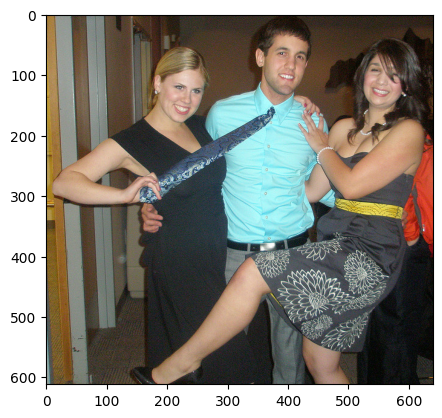

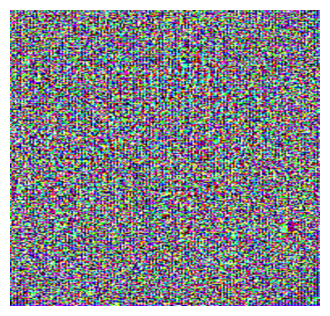

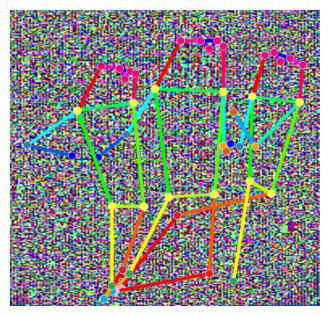

In [120]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

coco_annotation_file_path = '/datasets/work/icvg-phd-marsfield/work/Houke/coco2017/annotations/person_keypoints_train2017.json'
coco_images_dir = '/datasets/work/icvg-phd-marsfield/work/Houke/coco2017/train2017'
img_set = []
coco = COCO(coco_annotation_file_path)

image_id = 541949  # Example image id
image_info = coco.loadImgs(image_id)[0]
img_path = os.path.join(coco_images_dir, image_info['file_name'])

img = cv2.imread(img_path)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img2 = cv2.imread(img_path)
img2 = cv2.resize(img2, (192, 256))

plt.figure(figsize=(4, 7))
plt.axis('off')

img = img.astype(np.float32) / 255.0
sigma = 0
noise = np.random.laplace(0, sigma, img.shape)

img = img + noise
img = np.clip(img, 0, 1)

img = (img * 255).astype(np.uint8)


img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

img2 = img2.astype(np.float32) / 255.0

sigma = 0
noise = np.random.laplace(0, sigma, img2.shape)

noisy_img = img2 + noise
noisy_img = np.clip(noisy_img, 0, 1)

noisy_img = (noisy_img * 255).astype(np.uint8)



img_set.append(noisy_img)
transform = torchvision.transforms.ToTensor()
images = torch.stack([transform(img).to(device) for img in img_set])

annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id, iscrowd=False))

resize_hw = (256, 192)
weights_path = "/datasets/work/icvg-phd-marsfield/work/Houke/PP_Pose/COCO/final_model.pth"

data_transform = transforms.Compose([
    transforms.AffineTransform(scale=(1.25, 1.25), fixed_size=resize_hw),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

model = HighResolutionNet(base_channel=32, num_joints=17)
weights = torch.load(weights_path, map_location=device)
weights = weights if "model" not in weights else weights["model"]
model.load_state_dict(weights)
model.to(device)
model.eval()

predict_img = predict_all_person(coco, image_id, img, annotations, device, model, data_transform, images)

plt.figure(figsize=(4, 7))
plt.axis('off')
plt.imshow(predict_img)
plt.savefig('test_result_all_person_original.png', format='png')

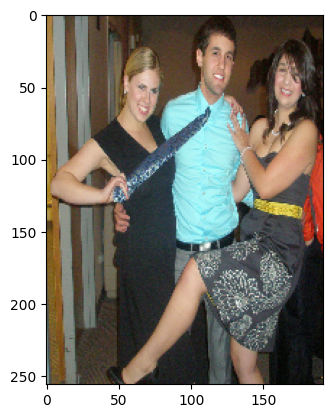

In [121]:
plt.imshow(noisy_img)

In [122]:
print(img.shape)

(612, 640, 3)
